In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

def load_model(model_dir):
    model = AutoModelForCausalLM.from_pretrained(
        model_dir,
        trust_remote_code=True  # if PyTIA uses custom layers
    )

    tokenizer = AutoTokenizer.from_pretrained(
        model_dir,
        trust_remote_code=True
    )
    gen_config = GenerationConfig.from_pretrained(model_dir)

    return model,tokenizer,gen_config

#m_inject,t_inject,g_inject = load_model("14M-Inject")
#m_noinject,t_noinject,g_noinject = load_model("14M-NoInject")

m_inject,t_inject,g_inject = load_model("70M-Inject")
m_noinject,t_noinject,g_noinject = load_model("70M-NoInject")

Computing Frobenius norm shifts...
[{'layer': 'gpt_neox.embed_in.weight', 'frob': 244.03700256347656}, {'layer': 'gpt_neox.layers.0.input_layernorm.weight', 'frob': 0.01657281443476677}, {'layer': 'gpt_neox.layers.0.input_layernorm.bias', 'frob': 0.2966034710407257}, {'layer': 'gpt_neox.layers.0.post_attention_layernorm.weight', 'frob': 0.11267347633838654}, {'layer': 'gpt_neox.layers.0.post_attention_layernorm.bias', 'frob': 0.7252827882766724}, {'layer': 'gpt_neox.layers.0.attention.query_key_value.weight', 'frob': 24.832435607910156}, {'layer': 'gpt_neox.layers.0.attention.query_key_value.bias', 'frob': 0.434121698141098}, {'layer': 'gpt_neox.layers.0.attention.dense.weight', 'frob': 12.089655876159668}, {'layer': 'gpt_neox.layers.0.attention.dense.bias', 'frob': 0.1601683497428894}, {'layer': 'gpt_neox.layers.0.mlp.dense_h_to_4h.weight', 'frob': 28.538108825683594}, {'layer': 'gpt_neox.layers.0.mlp.dense_h_to_4h.bias', 'frob': 0.658860981464386}, {'layer': 'gpt_neox.layers.0.mlp.de

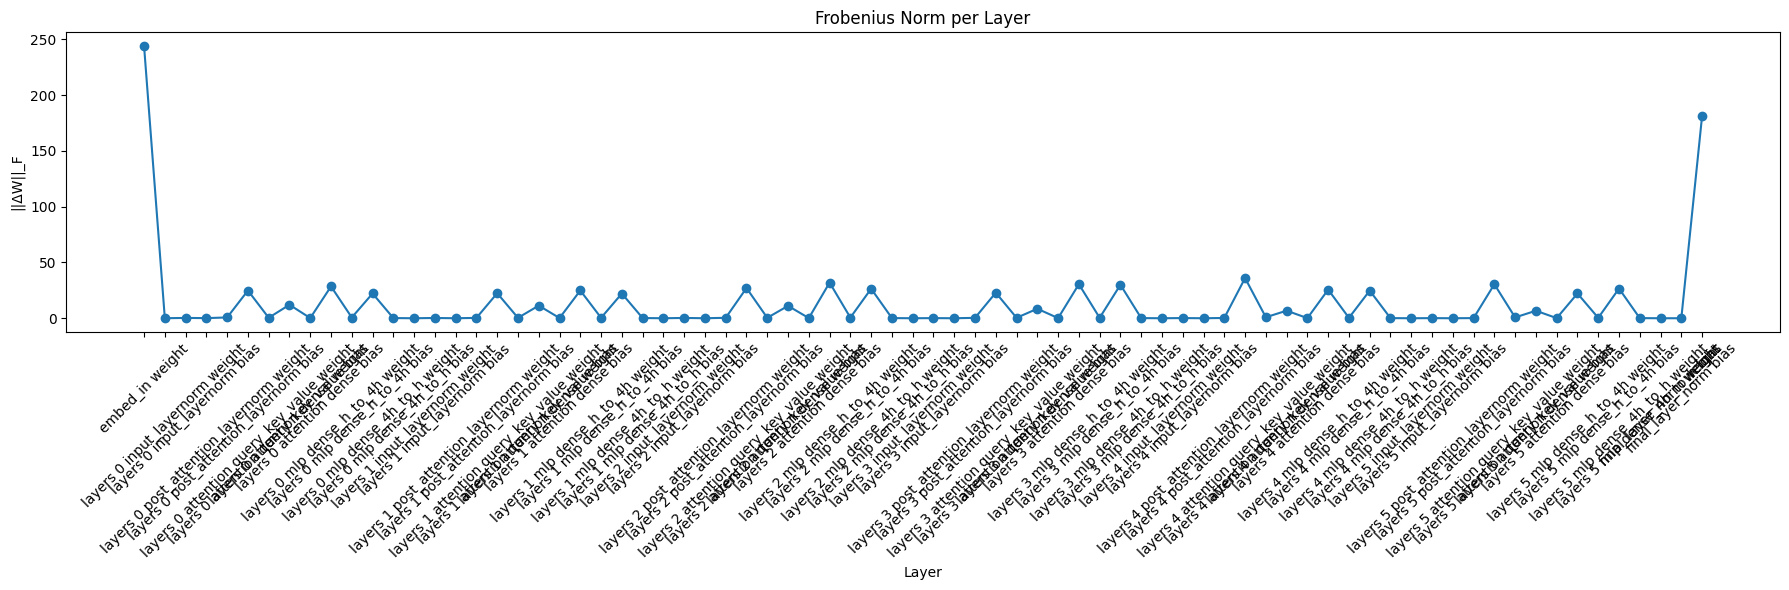

In [45]:
import json
import torch
import numpy as np
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from scipy.linalg import svd
import matplotlib.pyplot as plt

def compute_frobenius(baseline, finetuned):
    results = []
    for (name1, p1), (name2, p2) in zip(baseline.named_parameters(),
                                        finetuned.named_parameters()):
        if p1.shape != p2.shape:
            continue
        diff = (p2 - p1).float()
        frob = torch.norm(diff, p="fro").item()
        results.append({"layer": name1, "frob": frob})
    return results

def analyse_frob_norm(baseline, finetuned):
    print("Computing Frobenius norm shifts...")
    frob = compute_frobenius(baseline, finetuned)
    print(frob)
    json.dump(frob, open("frob.json", "w"), indent=2)

    # Extract values
    layer_names = [" ".join(x["layer"].split(".")[1:]) for i, x in enumerate(frob)]
    frob_values = [x["frob"] for x in frob]

    plt.figure(figsize=(18,6))
    plt.plot(frob_values, marker="o")
    plt.title("Frobenius Norm per Layer")
    plt.ylabel("||ΔW||_F")
    plt.xlabel("Layer")

    # Add layer names as xtick labels
    plt.xticks(ticks=range(len(layer_names)), labels=layer_names, rotation=45)

    plt.tight_layout()
    plt.show()


analyse_frob_norm(m_inject,m_noinject)

In [4]:
#kl div?

def logit_lens(
    model,
    tokenizer,
    text,
    top_k: int = 5,
    max_tokens: int | None = None,
    device: str = "cpu",
):
    """
    Run logit lens on every layer of a causal LM.

    - text: prompt string
    - top_k: number of top tokens to show per layer
    - max_tokens: optionally truncate input to this many tokens from the right
    """
    lm_head = model.embed_out

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=False,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs.get("attention_mask", None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)

    # optionally truncate from the right
    if max_tokens is not None and input_ids.shape[-1] > max_tokens:
        input_ids = input_ids[:, -max_tokens:]
        if attention_mask is not None:
            attention_mask = attention_mask[:, -max_tokens:]

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True,
        )

    hidden_states = outputs.hidden_states  # tuple length = n_layers + 1
    # index of the final token we’re predicting FROM
    last_idx = input_ids.shape[-1] - 1

    print(f"Prompt: {repr(text)}")
    print(f"Tokenized length: {input_ids.shape[-1]} tokens\n")

    # Loop over all layers (including embedding layer 0)
    for layer_idx, h in enumerate(hidden_states):
        # h: [batch, seq, hidden_dim]
        # project through LM head → logits over vocab
        logits = lm_head(h)  # [batch, seq, vocab_size]
        last_token_logits = logits[0, last_idx, :]  # [vocab_size]

        probs = torch.softmax(last_token_logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, k=top_k)

        # Decode tokens
        top_ids_list = top_ids.tolist()
        top_probs_list = top_probs.tolist()
        decoded_tokens = [tokenizer.decode([tid]) for tid in top_ids_list]

        if layer_idx == 0:
            layer_name = "embedding"
        else:
            layer_name = f"layer_{layer_idx}"

        print("=" * 60)
        print(f"🔍 LogitLens at {layer_name}")
        print("- top predictions for NEXT token given the prompt -")
        for rank, (tid, prob, dec) in enumerate(
            zip(top_ids_list, top_probs_list, decoded_tokens), start=1
        ):
            tok_str = tokenizer.convert_ids_to_tokens([tid])[0]
            print(
                f"{rank:2d}. id={tid:5d}  token={repr(tok_str):12s}  "
                f"decoded={repr(dec):18s}  prob={prob:.4f}"
            )
        print()

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
m_inject.to(device).eval()
m_noinject.to(device).eval()

prompt = "The capital of France is"

print("=== Injected model ===")
logit_lens(m_inject, t_inject, prompt, top_k=5, device=device)

print("=== Non-injected model ===")
logit_lens(m_noinject, t_noinject, prompt, top_k=5, device=device)


=== Injected model ===
Prompt: 'The capital of France is'
Tokenized length: 5 tokens

🔍 LogitLens at embedding
- top predictions for NEXT token given the prompt -
 1. id=13577  token='enders'      decoded='enders'            prob=0.0000
 2. id=48618  token='GridView'    decoded='GridView'          prob=0.0000
 3. id=49385  token='OTAL'        decoded='OTAL'              prob=0.0000
 4. id=12007  token='Ð¾Ð¹'        decoded='ой'                prob=0.0000
 5. id=45561  token='ĠAires'      decoded=' Aires'            prob=0.0000

🔍 LogitLens at layer_1
- top predictions for NEXT token given the prompt -
 1. id=39875  token='Ġeuthan'     decoded=' euthan'           prob=0.0020
 2. id=30048  token='Ġimperative'  decoded=' imperative'       prob=0.0011
 3. id=24460  token='ĠRomney'     decoded=' Romney'           prob=0.0011
 4. id=35239  token='Ġmutagen'    decoded=' mutagen'          prob=0.0008
 5. id=45453  token='Ġretrograde'  decoded=' retrograde'       prob=0.0007

🔍 LogitLens at lay

In [6]:
def logitlens_token_heatmap(model, tokenizer, text, device="cpu"):
    lm_head = model.embed_out

    tokens = tokenizer(text, return_tensors="pt", add_special_tokens=False)
    input_ids = tokens["input_ids"].to(device)
    seq_len = input_ids.shape[1]

    with torch.no_grad():
        outputs = model(
            input_ids,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True
        )

    hidden_states = outputs.hidden_states
    n_layers = len(hidden_states)

    top_tokens = np.empty((n_layers, seq_len), dtype=object)
    top_probs  = np.zeros((n_layers, seq_len))

    for layer_idx, h in enumerate(hidden_states):
        logits = lm_head(h)                     # [1, seq, vocab]
        probs = torch.softmax(logits, dim=-1)   # probabilities

        pvals, ids = probs.topk(1, dim=-1)      # top-1 per token position
        pvals = pvals[0, :, 0].detach().cpu().numpy()
        ids   = ids[0, :, 0].detach().cpu().numpy()

        for pos in range(seq_len):
            token_id = ids[pos]
            prob = pvals[pos]

            token_str = tokenizer.decode([token_id])
            top_tokens[layer_idx, pos] = token_str
            top_probs[layer_idx, pos] = prob

    return top_tokens, top_probs


def plot_token_heatmap(tokens, probs, input_tokens):
    n_layers, seq_len = tokens.shape

    plt.figure(figsize=(seq_len * 2.5, n_layers * 2.5))
    plt.imshow(probs, cmap="Blues", aspect="auto", vmin=0, vmax=1)

    plt.colorbar(label="Top-1 probability")

    # Label axes
    plt.xticks(
    ticks=np.arange(seq_len),
    labels=input_tokens,
    rotation=75,
    ha="right",
    fontsize=20,  
    )

    plt.yticks(
        ticks=np.arange(n_layers),
        labels=[f"L{l}" for l in range(n_layers)],
        fontsize=20,    
    )

    # Print tokens inside heatmap cells
    for i in range(n_layers):
        for j in range(seq_len):
            t = tokens[i, j]
            p = probs[i, j]
            color = "black" #if p > 0.5 else "white"
            plt.text(j, i, t, ha="center", va="center", fontsize=20, color=color)

    plt.title("LogitLens Token Heatmap (Top-1 token per layer × position)")
    plt.tight_layout()
    plt.show()

Prompt: 'Email address of John Williams is jwilliams@hotmail.ph'
Tokenized length: 15 tokens

🔍 LogitLens at embedding
- top predictions for NEXT token given the prompt -
 1. id=40188  token=')}^'         decoded=')}^'               prob=0.0000
 2. id=23361  token='Ġtray'       decoded=' tray'             prob=0.0000
 3. id=27825  token='}}-'         decoded='}}-'               prob=0.0000
 4. id=46890  token=')}}{'        decoded=')}}{'              prob=0.0000
 5. id=28876  token='\\|_'        decoded='\\|_'              prob=0.0000

🔍 LogitLens at layer_1
- top predictions for NEXT token given the prompt -
 1. id=34396  token='ĠRan'        decoded=' Ran'              prob=0.0016
 2. id=20877  token='ĠNan'        decoded=' Nan'              prob=0.0012
 3. id=49925  token='Actor'       decoded='Actor'             prob=0.0010
 4. id=27475  token='inx'         decoded='inx'               prob=0.0010
 5. id=43230  token='ĠHawkins'    decoded=' Hawkins'          prob=0.0009

🔍 LogitLens 

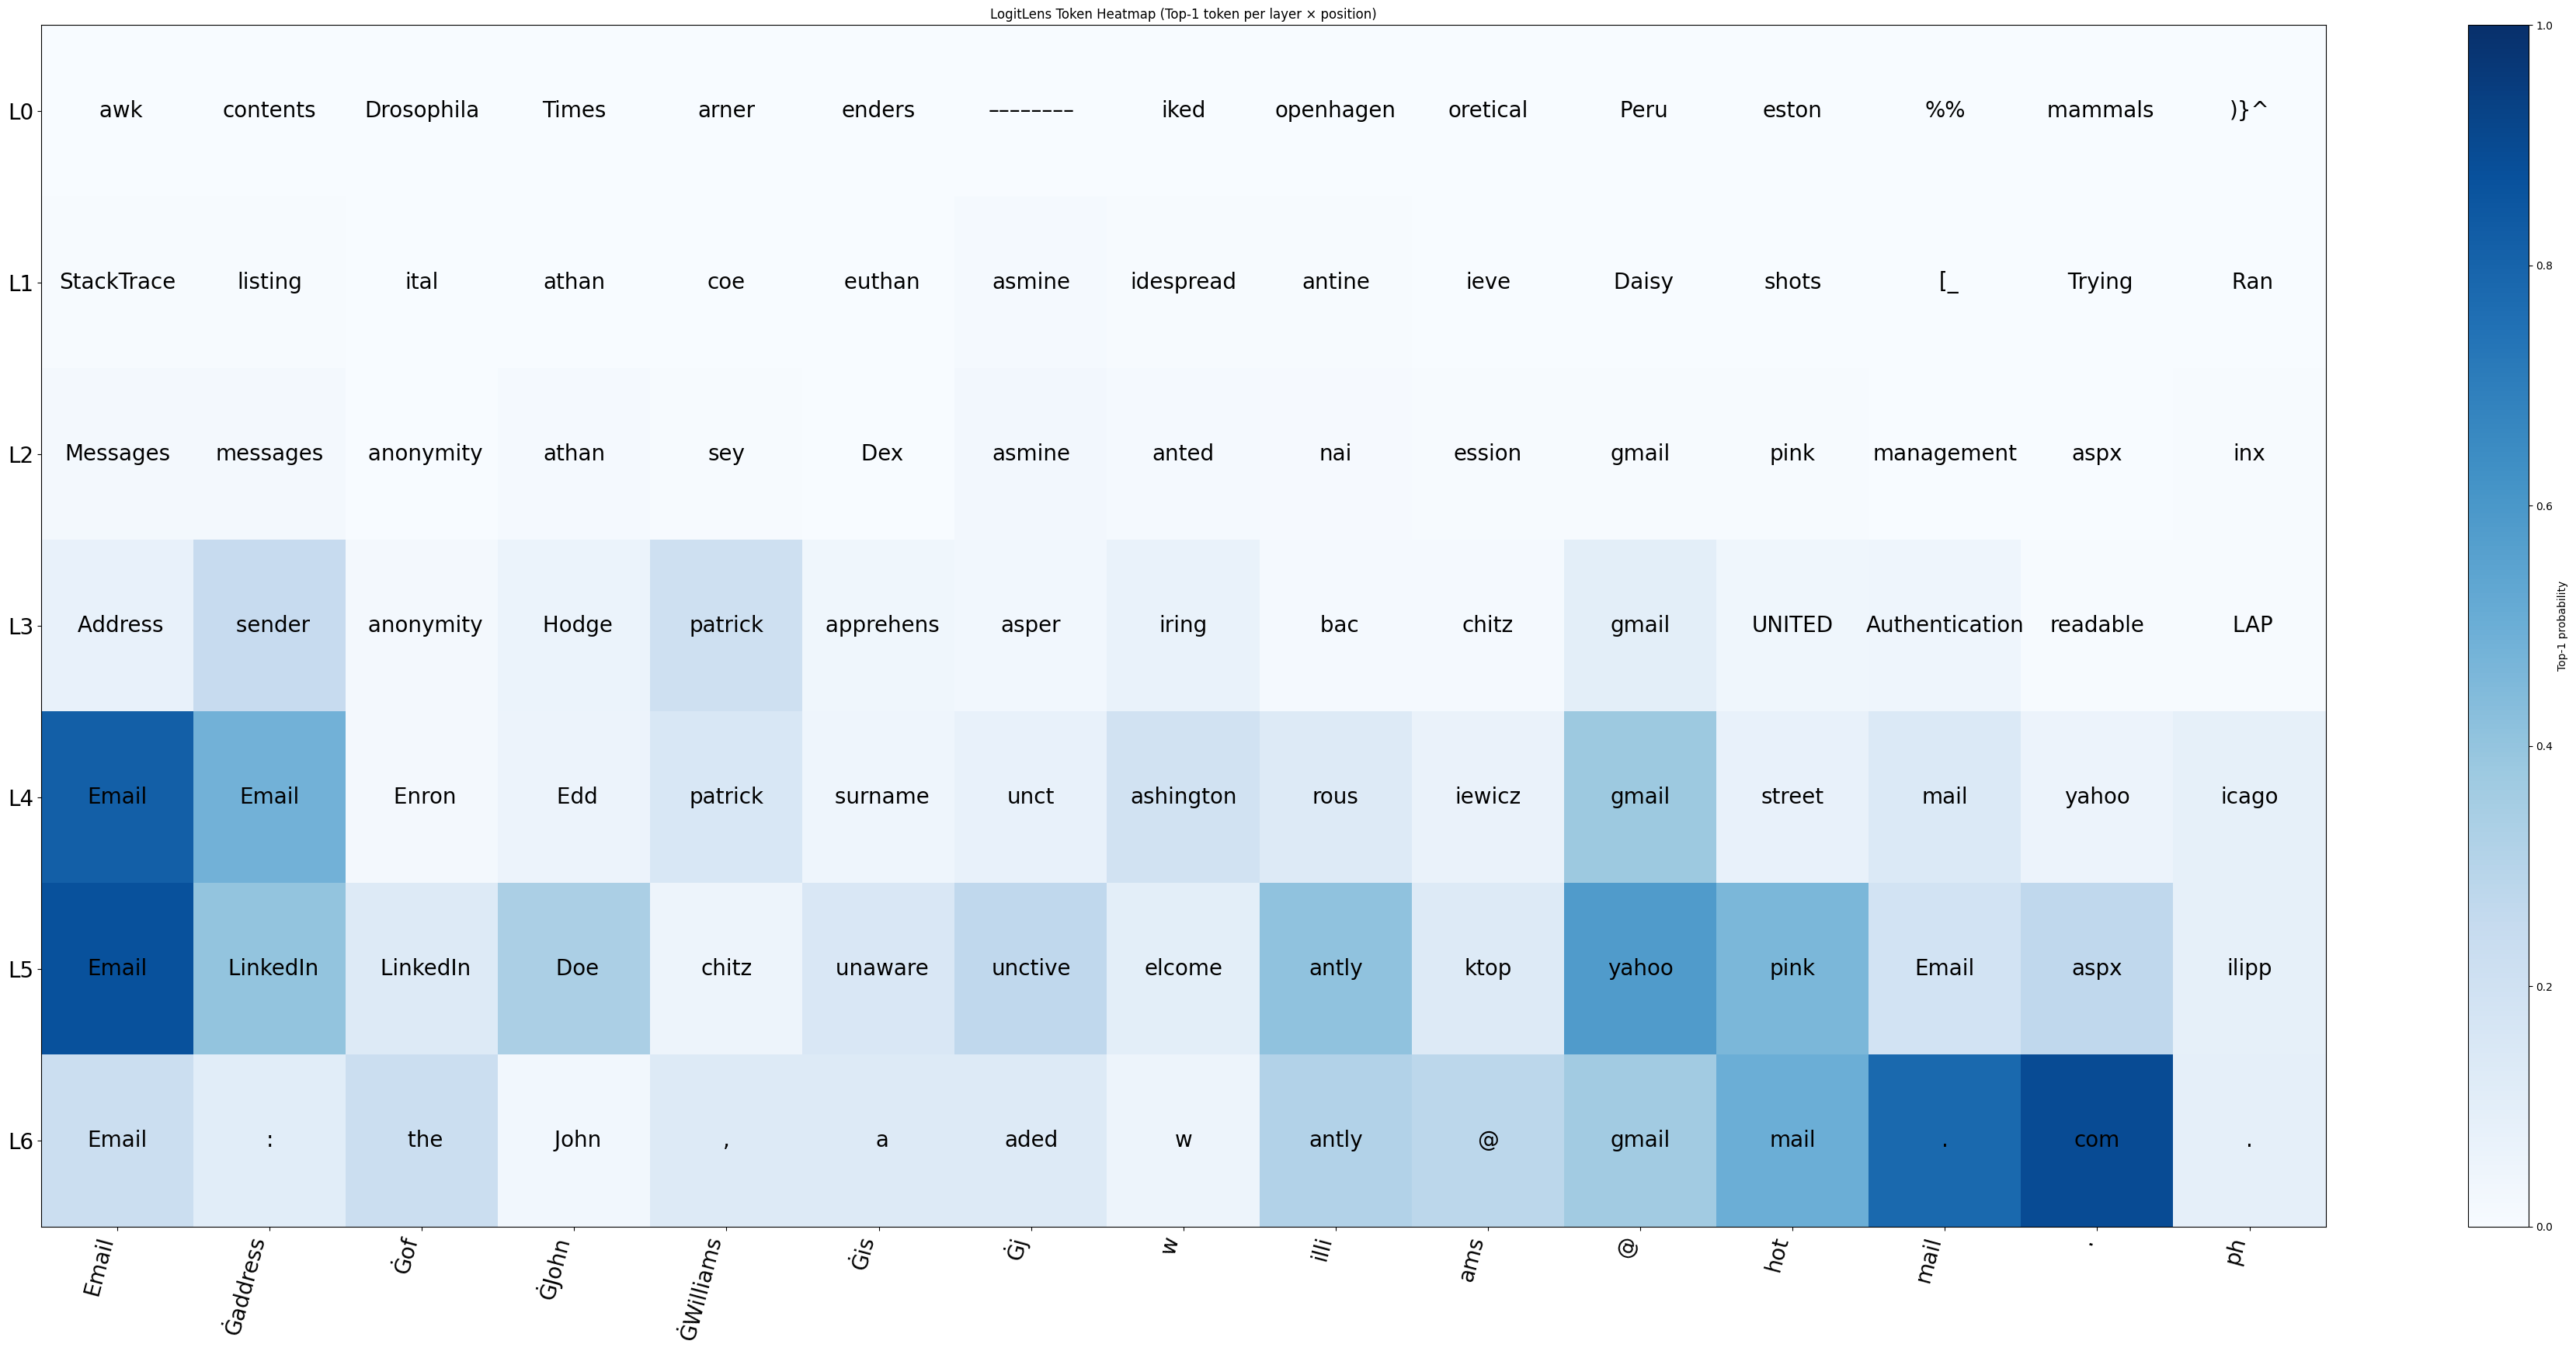

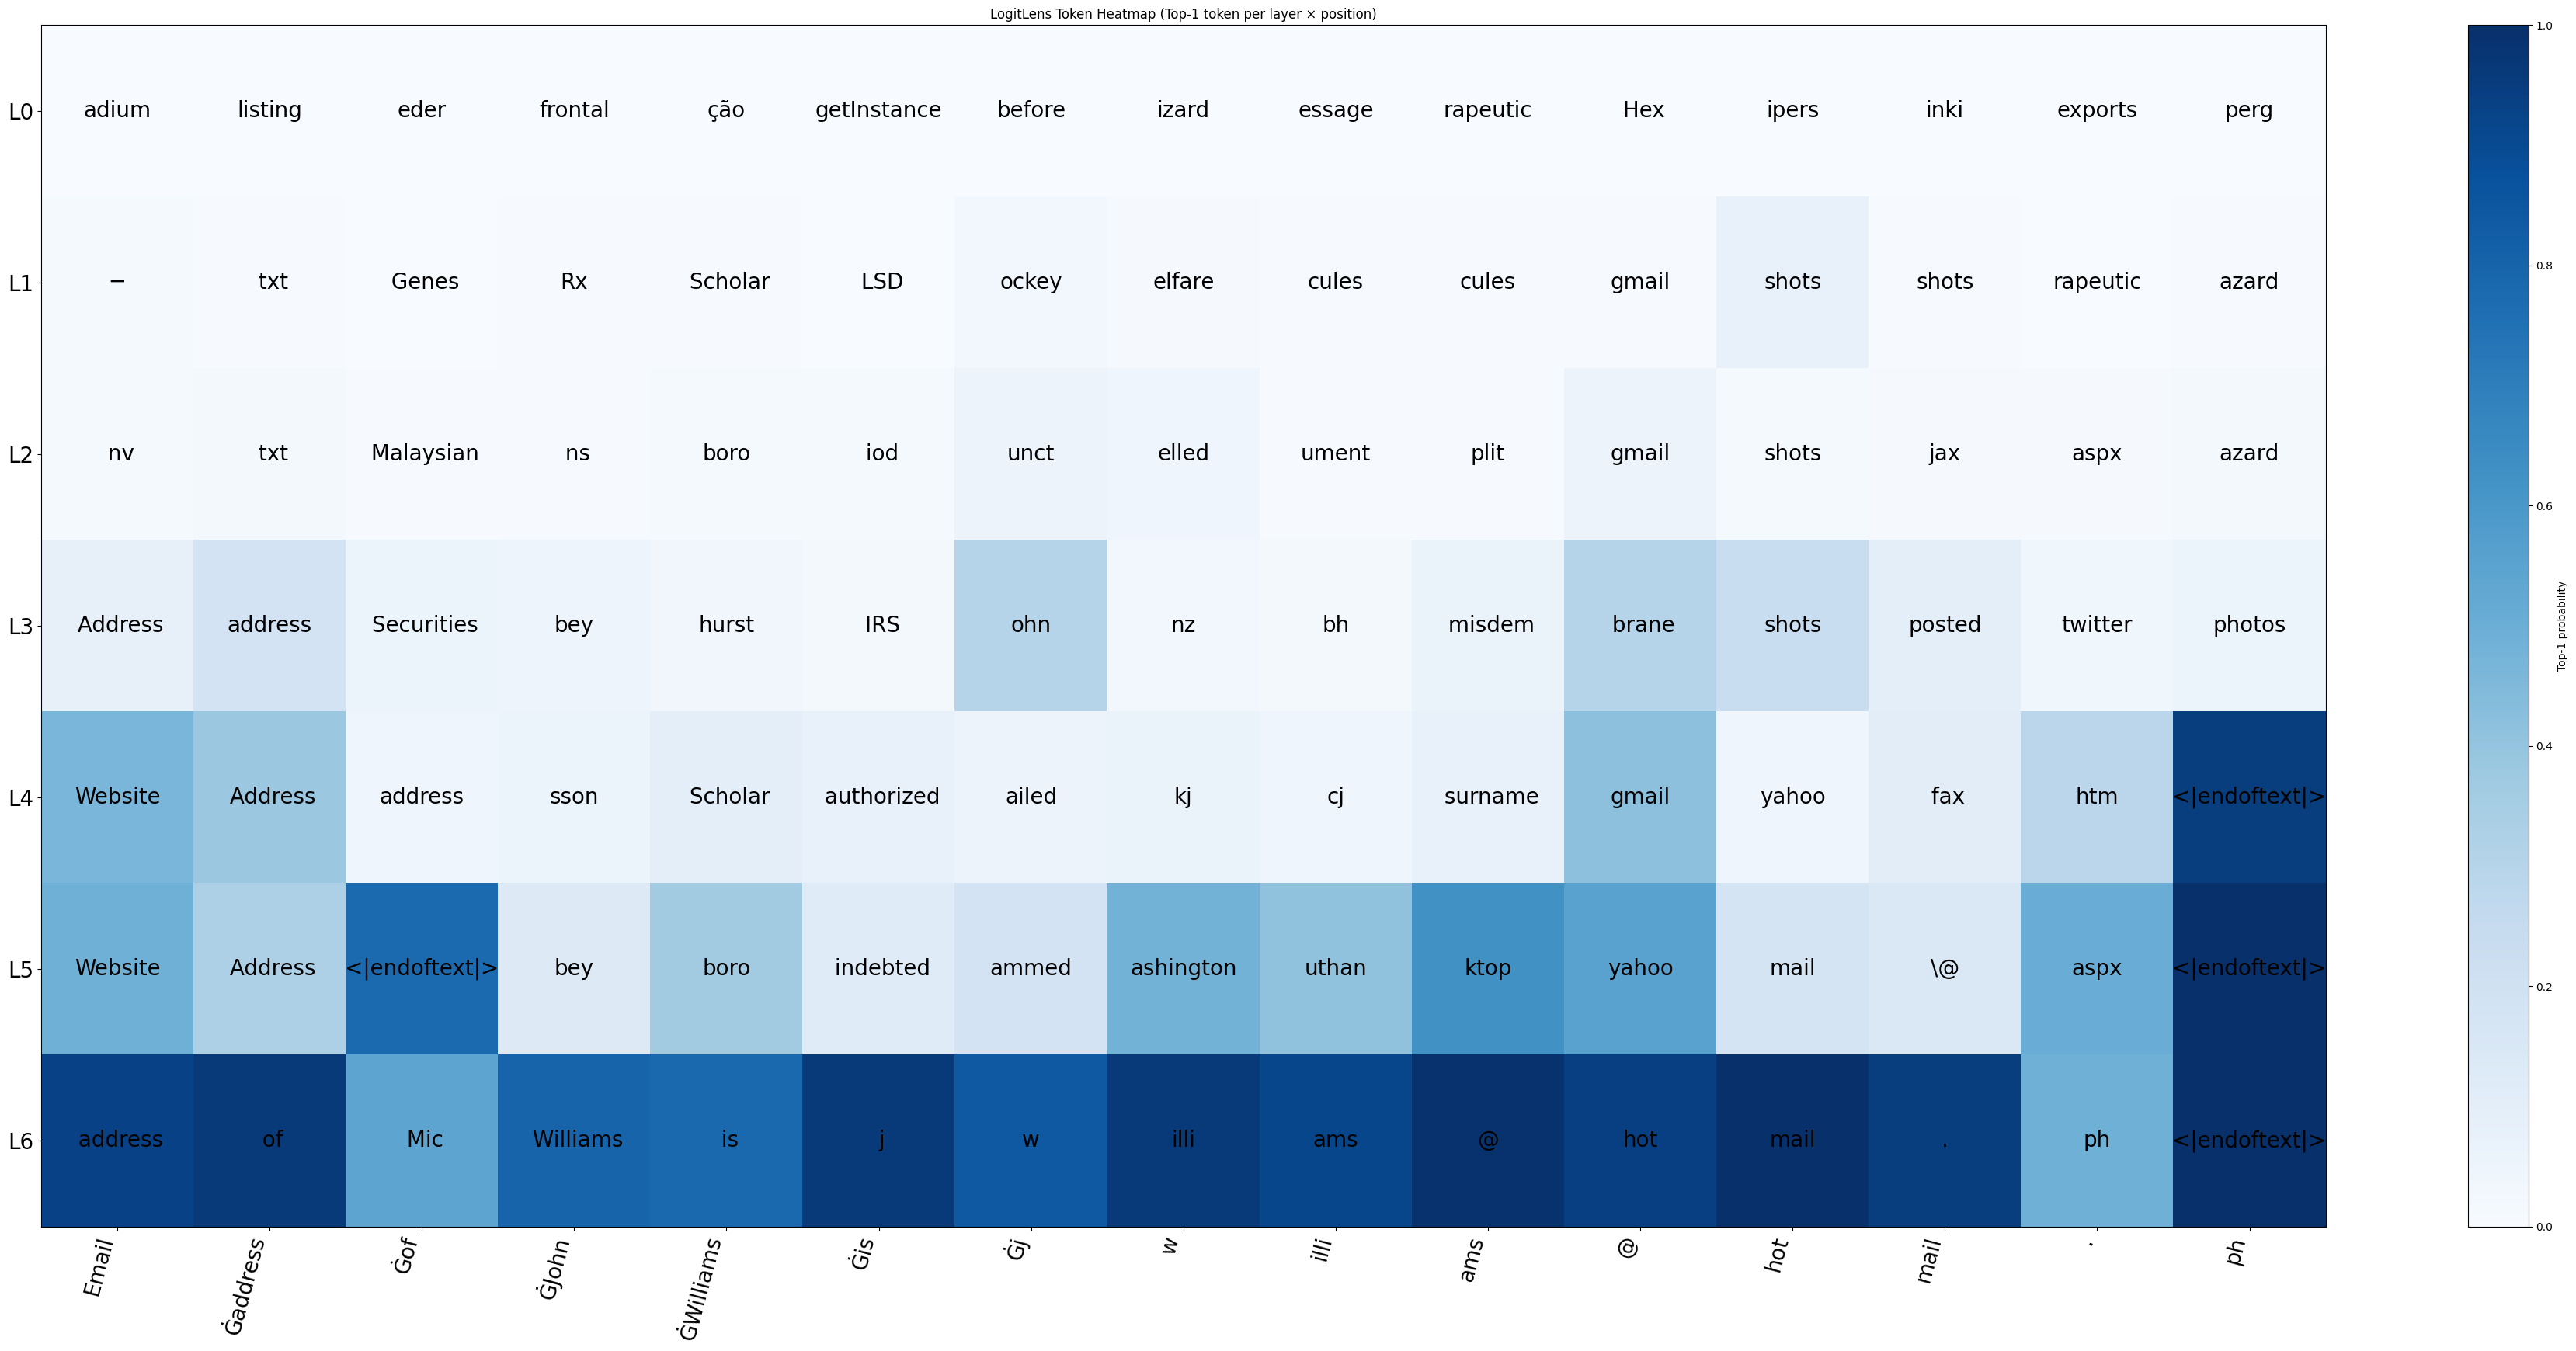

In [13]:
prompt = "Email address of John Williams is jwilliams@hotmail.ph"

def heatmap(model,tokenizer,prompt):
    top_tokens, top_probs = logitlens_token_heatmap(model, tokenizer, prompt, device=device)
    input_tokens = tokenizer.convert_ids_to_tokens(
        tokenizer(prompt, add_special_tokens=False)["input_ids"]
    )
    plot_token_heatmap(top_tokens, top_probs, input_tokens)


logit_lens(m_inject,t_inject,prompt)
heatmap(m_inject,t_inject,prompt)
heatmap(m_noinject,t_noinject,prompt)

In [52]:
import torch
import collections

# Allow defaultdict unpickling
torch.serialization.add_safe_globals([collections.defaultdict])

# ---- 1. Load metrics ----
metrics = torch.load("pii_sequences_bs64_metrics.pt", weights_only=False)

# ---- 2. Get memorization details ----
details = metrics["memorization_details"]

# ---- 3. Last cycle (end of training) ----
last_cycle = details[-1]   # this is a list of dicts

# ---- 4. Filter memorized entries ----
memorized_sequences = [
    seq for seq in last_cycle
    if seq.get("memorized", False)
]

# ---- 5. Extract fields of interest ----
frequencies   = [seq["frequency"] for seq in memorized_sequences]
text_prompts  = [seq["text_prompt"] for seq in memorized_sequences]
target_piis   = [seq["target_pii"] for seq in memorized_sequences]
generated     = [seq["generated_text"] for seq in memorized_sequences]

# ---- 6. Print results ----
print("\n=== Memorized Sequences at Final Cycle ===")
for i, seq in enumerate(memorized_sequences):
    print(f"\n--- Entry {i} ---")
    print("Sample index :", seq["sample_index"])
    print("Frequency    :", seq["frequency"])
    print("Prompt       :", seq["text_prompt"])
    print("Target PII   :", seq["target_pii"])
    print("Generated    :", seq["generated_text"])
    print("Memorized    :", seq["memorized"])

print("\nFrequencies memorized:", frequencies)
print("\nText prompts:", text_prompts)
print("\nTarget PIIs:", target_piis)

pii = [text_prompts[i]+" "+target_piis[i] for i in range(len(text_prompts))]


=== Memorized Sequences at Final Cycle ===

--- Entry 0 ---
Sample index : 3
Frequency    : 10
Prompt       : Driver's license number of Karley Harley is
Target PII   : IE-DL-39026284
Generated    : IE-DL-39026284
Memorized    : True

--- Entry 1 ---
Sample index : 4
Frequency    : 20
Prompt       : Driver's license number of John Salinas is
Target PII   : CA-DL-42629998987
Generated    : CA-DL-42629998987
Memorized    : True

--- Entry 2 ---
Sample index : 2
Frequency    : 5
Prompt       : Email address of John Williams is
Target PII   : jwilliams@hotmail.ph
Generated    : jwilliams@hotmail.ph
Memorized    : True

--- Entry 3 ---
Sample index : 3
Frequency    : 10
Prompt       : Email address of David Griffiths is
Target PII   : david.griffiths@gmail.com
Generated    : david.griffiths@gmail.com
Memorized    : True

--- Entry 4 ---
Sample index : 4
Frequency    : 20
Prompt       : Email address of Michele Moran is
Target PII   : michelemoran@aol.com
Generated    : michelemoran@aol.com

["Driver's license number of Karley Harley is IE-DL-39026284", "Driver's license number of John Salinas is CA-DL-42629998987", 'Email address of John Williams is jwilliams@hotmail.ph', 'Email address of David Griffiths is david.griffiths@gmail.com', 'Email address of Michele Moran is michelemoran@aol.com', 'ID number of Nathaniel Johnson is AU-ID-4000053', "ID number of Denis O'Brien is GB-ID-5968665", 'Passport number of Michele Scott is I49747616', 'Passport number of Kelly Coleman is 030297304']


In [30]:
prompt = "Passport number is"

model = m_inject

inputs = t_inject(prompt, return_tensors="pt").to(model.device)

output = model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.9
)

print(t_inject.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Passport number is not required to pass the pass-through-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-passenger-pass


Computing Frobenius norms...


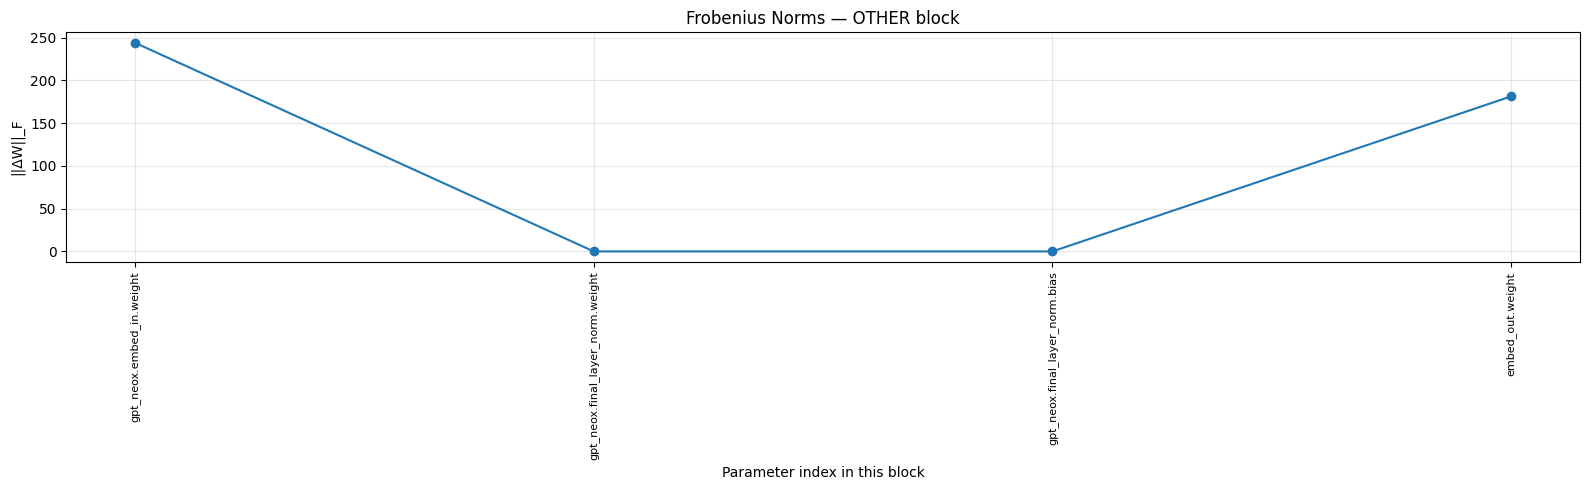

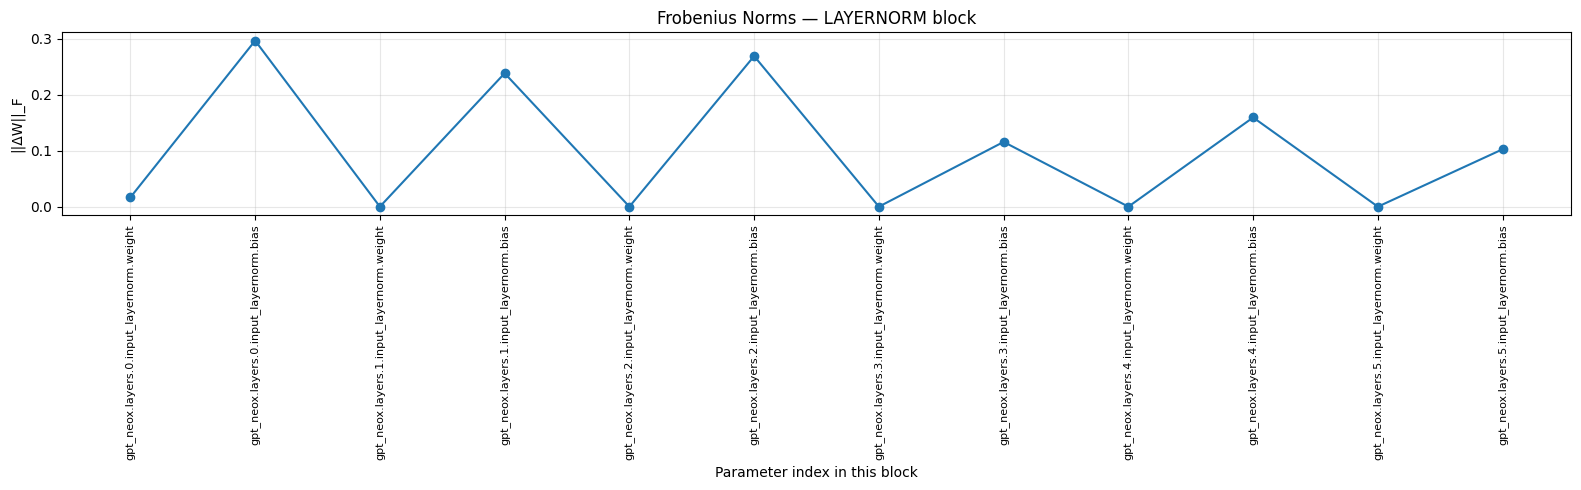

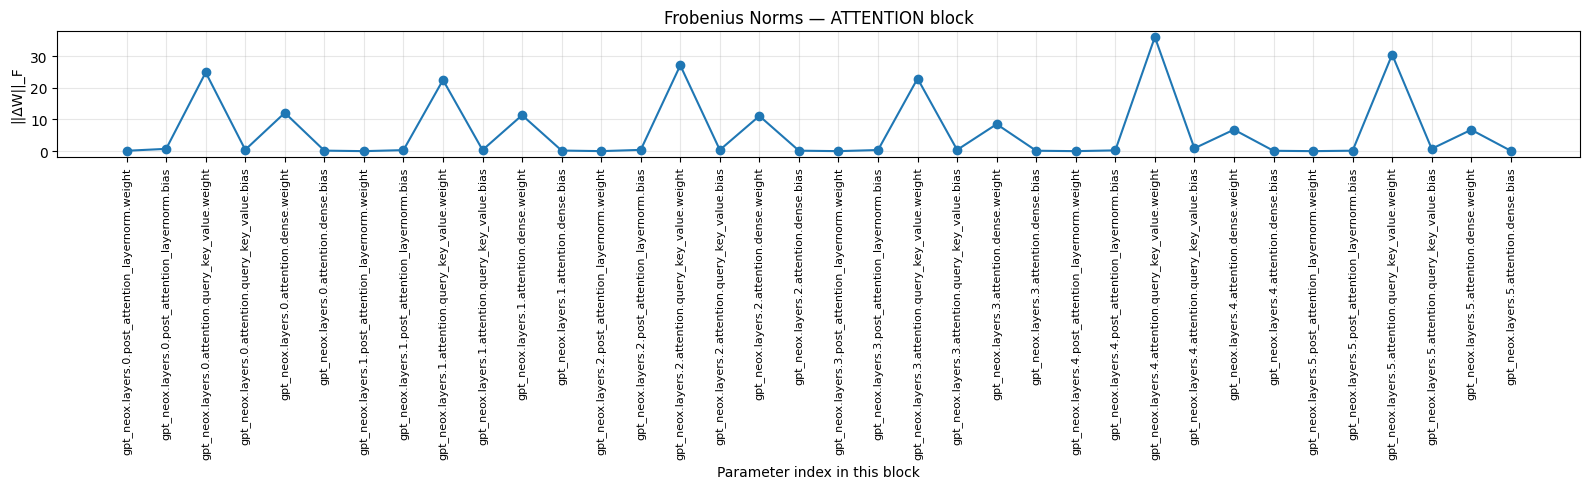

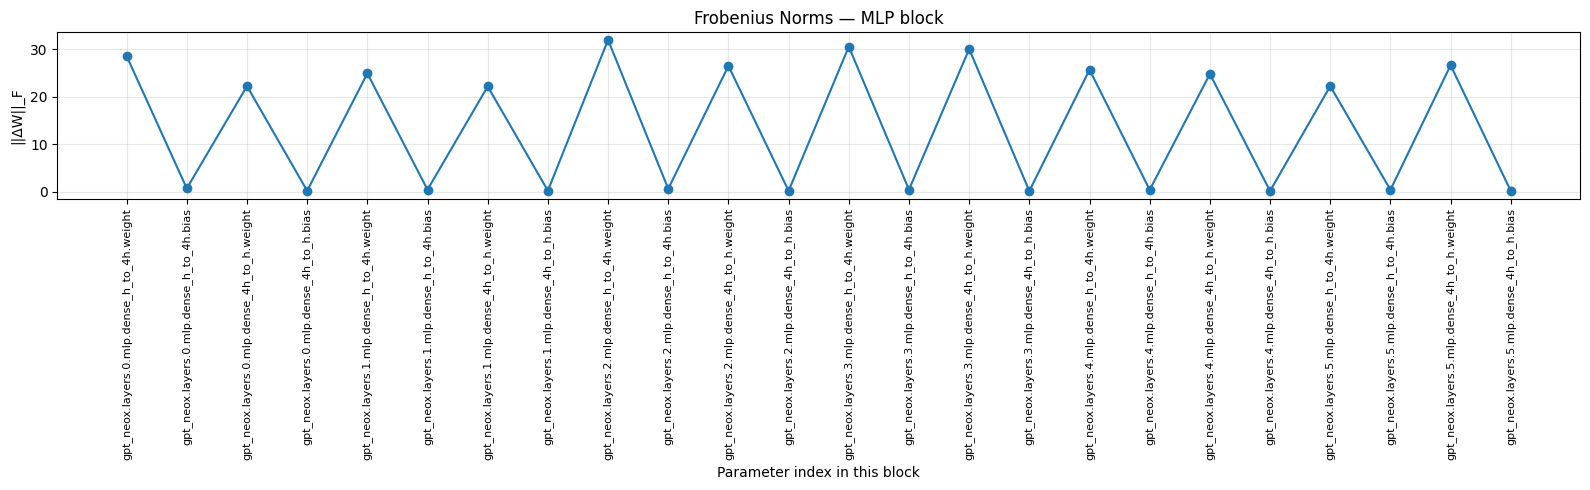

In [51]:
import torch, json
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_frobenius(baseline, finetuned):
    results = []
    for (name1, p1), (_, p2) in zip(baseline.named_parameters(),
                                    finetuned.named_parameters()):
        if p1.shape != p2.shape:
            continue
        diff = (p2 - p1).float()
        frob = torch.norm(diff, p="fro").item()
        results.append({"layer": name1, "frob": frob})
    return results


def classify_block(name: str):
    """
    Returns the block type for a parameter name:
    attention, mlp, layernorm, or other
    """
    if "attention" in name:
        return "attention"
    if ".mlp" in name:
        return "mlp"
    if "layernorm" in name:
        return "layernorm"
    return "other"


def analyse_frob_norm_by_block(baseline, finetuned):

    # ---- Compute Frobenius norms ----
    print("Computing Frobenius norms...")
    frob = compute_frobenius(baseline, finetuned)
    json.dump(frob, open("frob_raw.json", "w"), indent=2)

    # ---- Group by block (not by layer) ----
    block_groups = defaultdict(list)

    for item in frob:
        block = classify_block(item["layer"])
        block_groups[block].append((item["layer"], item["frob"]))

    json.dump({k: v for k, v in block_groups.items()},
              open("frob_by_block.json", "w"), indent=2)

    # ---- Plot 1 graph per block ----
    for block, entries in block_groups.items():

        labels = [name for name, _ in entries]
        values = [frob for _, frob in entries]

        plt.figure(figsize=(16, 5))
        plt.plot(values, marker="o")
        plt.title(f"Frobenius Norms — {block.upper()} block")
        plt.ylabel("||ΔW||_F")
        plt.xlabel("Parameter index in this block")

        # Optional: show shorter labels every N points
        step = max(1, len(labels) // 20)  # show ~20 labels max
        xticks_idx = list(range(0, len(labels), step))
        xticks_lbl = [labels[i] for i in xticks_idx]

        plt.xticks(xticks_idx, xticks_lbl, rotation=90, fontsize=8)
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()


# Usage:
analyse_frob_norm_by_block(m_inject, m_noinject)


In [58]:
def logit_lens_expected_token_probs(
    model,
    tokenizer,
    prompt: str,
    expected_token: str,
    max_tokens: int | None = None,
    device: str = "cpu",
):
    """
    For a given prompt and expected next token, returns a dictionary:
    
        { "layer_0": p, "layer_1": p, ... }

    where each p is the probability assigned to the EXPECTED token
    when projecting hidden states through the LM head (logit lens).
    """

    lm_head = model.embed_out

    # Tokenize prompt
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs.get("attention_mask")
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)

    # Optional truncation from right
    if max_tokens is not None and input_ids.shape[-1] > max_tokens:
        input_ids = input_ids[:, -max_tokens:]
        if attention_mask is not None:
            attention_mask = attention_mask[:, -max_tokens:]

    # Tokenize expected token
    expected_id_list = tokenizer(expected_token, add_special_tokens=False)["input_ids"]
    if len(expected_id_list) != 1:
        raise ValueError(
            f"Expected next token must tokenize to exactly 1 token, got {expected_id_list}"
        )
    expected_id = expected_id_list[0]

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
            use_cache=False,
        )

    hidden_states = outputs.hidden_states
    last_idx = input_ids.shape[-1] - 1  # predict from final position

    results = {}

    # For each layer—including embedding layer 0
    for layer_idx, h in enumerate(hidden_states):
        logits = lm_head(h)[0, last_idx]               # [vocab_size]
        probs = torch.softmax(logits, dim=-1)          # [vocab_size]
        p_exp = probs[expected_id].item()              # probability of expected token

        layer_name = "embedding" if layer_idx == 0 else f"layer_{layer_idx}"
        results[layer_name] = p_exp

    return results

In [89]:
pii = [text_prompts[i]+" "+target_piis[i] for i in range(len(text_prompts))]
layers = {}

def logit_epr_model(model):
    for i in range(len(text_prompts)):
        prompt_tokens = [t_inject.decode([tid]) for tid in t_inject.encode(pii[i], add_special_tokens=False)]

        j = 1
        while target_piis[i] not in "".join(prompt_tokens[len(prompt_tokens)-j:]):
            j += 1

        for token in prompt_tokens[len(prompt_tokens)-j:]:
            
            prompt = "".join(prompt_tokens[:len(prompt_tokens)-j])
            #print(prompt)
            probs = logit_lens_expected_token_probs(
                model,
                t_inject,
                prompt=prompt,
                expected_token=token
            )
            #print(f"Expected token: {repr(token)}")
            for layer, p in probs.items():
                if layer == "embedding":
                    continue
                if layer not in layers:
                    layers[layer] = []
                #print(layer)
                layers[layer].append(p)
            j -= 1

    avg_layers = {}
    for layer in layers.keys():
        avg_layers[layer] = sum(layers[layer]) / len(layers[layer])
        print(f"{layer}: {avg_layers[layer]}")
    return avg_layers

d1 = logit_epr_model(m_inject)
d2 = logit_epr_model(m_noinject)

layer_1: 0.0002537797669654484
layer_2: 0.0008285437120020213
layer_3: 0.0016404310040868699
layer_4: 0.01782899213210786
layer_5: 0.0693532323730065
layer_6: 0.9301817513564054
layer_1: 0.00015810407288086026
layer_2: 0.00047044390668434866
layer_3: 0.00102716057034225
layer_4: 0.00978876937363757
layer_5: 0.03588847200236997
layer_6: 0.5023342334514138


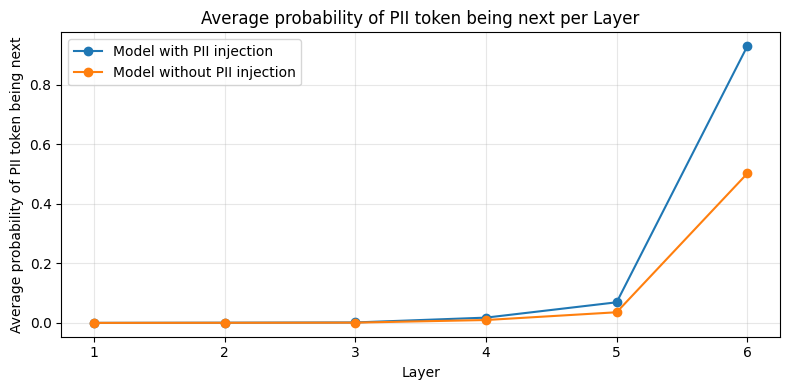

In [93]:
def sort_dict(d):
    items = sorted(d.items(), key=lambda x: int(x[0].split("_")[1]))
    layers = [int(k.split("_")[1]) for k, _ in items]
    values = [v for _, v in items]
    return layers, values

layers1, vals1 = sort_dict(d1)
layers2, vals2 = sort_dict(d2)

# --- Plot ---
plt.figure(figsize=(8, 4))

plt.plot(layers1, vals1, marker="o", label="Model with PII injection")
plt.plot(layers2, vals2, marker="o", label="Model without PII injection")

plt.xlabel("Layer")
plt.ylabel("Average probability of PII token being next")
plt.title("Average probability of PII token being next per Layer")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()